# QUESTIONS

- How do I create a "baseline" (50% accuracy) neural network? (not an FSM, as is currently used)
    - Doesn't need to be a neural network. One model could be just predicting the most common class. Alternatively, randomly guessing 0 or 1
- After choosing final model based on top performance on validation data, should I then train the model on training *and* validation dataset together before testing on "Test" data?
    - Yes, run on combo of train and val
- What else is there to discuss in the Conclusion/Findings sections aside from performance metrics?
    - Describe the *why* this may be the best model (e.g. overly complex/overfitting)
    - Describe *why* the metric you used is the best metric. Also, what does this metric mean in terms of the business problem (x% FP, x% FN, etc.)
- After adding markdown commentary and code commentary, is this notebook comprehensive enough to be an MVP?
    - Consider adding more details on exploring data (shapes, etc.)
    - Any interesting facts at this stage? Perhaps there aren't any
    - Is there a clearly defined business problem, including the metrics that will be used.
    - As you go from one model to the other, mention why you decided to explore that way
    
- What images can I include in presentation? I understand Lime and SHAP can produce images, but that is only one type of image. We're supposed to include 3-5+. 
- Take a look at accuracy plots. Are these similar to what would be expected?



### Notes for future development
- Use small batch size and incorporate "generator" into the model fit() instead of importing all data to numpy array in memory    

## Part 1. Import packages and data

The below packages are necessary for various functionality throughout the analysis

In [51]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys

# Use Scikit-learn for train-test splits and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Import various Keras/Tensorflow packages for neural networks
import keras
from keras import regularizers
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import *

# Global static variable declarations
RANDOM_STATE = 2020 # Ensure repeatable results
VAL_SPLIT = 0.25 # Use 25% of data for validation and test splits

# Set resolution of each photo. Each image is downsampled to this size (in pixels)
TARGET_SIZE = 128

Since this project has been run using local CPUs in addition to the GPUs offered by Google Colab and Kaggle Notebooks, the below cell quickly enables to user to select

In [17]:
# Set 'platform' to any of the following: "kaggle", "colab", "local" depending on use case
platform = 'kaggle'

def set_data_path(platform):
    
    # Set file paths if running on Kaggle notebook
    if platform == 'kaggle':
        path_train = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/'
        path_val   = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/'
        path_test  = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/'
    
    # Set file paths if running on Google Colab
    elif platform == 'colab':
        path_train = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/train'
        path_val   = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/val'
        path_test  = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/test'
        
        # Notebook must be "mounted" to drive to access stored data files
        from google.colab import drive
        drive.mount('/content/drive')

    # Set file paths if running locally
    elif platform == 'local':
        path_train = '../data/raw/train'
        path_val = '../data/raw/val'
        path_test  = '../data/raw/test'

    else:
        sys.exit('ERROR: PLEASE ENTER "kaggle", "colab" or "local"')
    
    return path_train, path_val, path_test


# Run function to determine the data paths for the platform being used
path_train, path_val, path_test = set_data_path(platform)

### Part 1a. Data Imports
It has been made clear through external research that substantial data within the provided Test dataset has been mislabeled. As a result, a model cannot effectively predict correctly when trained on correctly labeled data. To address the issue, data from both Train and Test folders are imported, combined, then randomly split within this notebook. This minimizes the impact of mislabeled data and in turn creates a model that is more generalizable.

##### Create function to import all images from provided directory

In [21]:
def import_data(path, file_ct, resolution=TARGET_SIZE):
    # Batch size is defined such that *all* images in selected folder are imported in one batch
        
        
    # Instantiate Keras generator, scaling all RGB inputs from the 
    # default [0, 255] range to the [0, 1] range since neural network inputs should be 
    # normalized
    generator = ImageDataGenerator(rescale=1/255)

    # Create flow object to bring images from folders to memory
    gen_train = generator.flow_from_directory(directory=path, 
                                              target_size=(resolution, resolution), 
                                              batch_size=file_ct, 
                                              seed=RANDOM_STATE)
    # Store all images in numpy array
    data_and_labels = next(gen_train)

    
    return data_and_labels[0], data_and_labels[1] # images, labels

##### Run function for train, validation, and test datasets. Then aggregate each into one final dataset.

In [30]:
# Number of images selected folder
file_ct_train = 1349 + 3883
file_ct_val = 8 + 8
file_ct_test = 234 + 390

# Run above-defined function for each of the datasets
images, labels = import_data(path_train, file_ct_train)
images_val, labels_val = import_data(path_val, file_ct_val)
images_test, labels_test = import_data(path_test, file_ct_test)

# Aggregate all datasets into one for inputs and one for outputs
images = np.concatenate([images, images_val, images_test], axis=0)
labels = np.concatenate([labels, labels_val, labels_test], axis=0)

# Remove unnecessary data since memory issues can occur while running this script
del images_val, labels_val
del images_test, labels_test

# Enhance data understanding. Verify all images are imported as would be expected
print('Image data shape:', images.shape)
print('Label data shape:', labels.shape)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Image data shape: (5856, 128, 128, 3)
Label data shape: (5856, 2)


##### Perform a train-test split on all data

In [31]:
# Classic train-test split for TEST data
x_train, x_test, y_train, y_test = train_test_split(images, labels, 
                                                  random_state=RANDOM_STATE, 
                                                  test_size=VAL_SPLIT)

# Classic train-test split for VALIDATION data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  random_state=RANDOM_STATE, 
                                                  test_size=VAL_SPLIT)


# Remove unnecessary data since memory issues can occur while running this script
del images
del labels

## Step 2. Modeling

This section iteratively creates and improves models to find the top performer. 

##### Define function to plot the performance of a model across epoch iterations

In [68]:
def plot_metrics(history, metrics=['accuracy'], val=True):
    
    # Create one plot for each metric being analyzed
    for metric in metrics:
        
        # Normalize casing to reduce possible errors
        metric=str.lower(metric)
        
        # Define 'x' variable according to the number of epochs
        x = range(len(history[metric]))

        # Create figure and plot the metric
        plt.figure()
        plt.plot(x, history[metric], label='Train')

        # If a validation split was used, plot its performance
        if val == True:
            plt.plot(x, history['val_'+metric], label='Validation')
        
        # Basic figure improvements
        plt.xlabel('Epochs')
        plt.title(metric)
        plt.legend();

##### Create function to plot the confusion matrices for models used downstream

In [45]:
def show_confusion_matrix(model, images, labels):
    # Reformat the "Labels" data to enable ease of use of Confusion Matrix
    truth = (labels[:, 1]==1).astype('int')
    
    # Predict Labels using the inputted model
    preds = np.argmax(model.predict(images), axis=-1)

    # Instantiate confusion matrix, NOT normalized
    matrix = confusion_matrix(truth, preds)#, normalize='true')
    ConfusionMatrixDisplay(matrix).plot()
    plt.xticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
    plt.yticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.title('Correctness of Model Predictions (COUNT)');

    # Instantiate confusion matrix, NORMALIZED
    matrix_norm = confusion_matrix(truth, preds, normalize='true')
    ConfusionMatrixDisplay(matrix_norm).plot()
    plt.xticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
    plt.yticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.title('Correctness of Model Predictions (%)')
    
    return matrix, matrix_norm

##### Create one function to aggregate the previously-defined two functions, in addition to printing several performance metrics

In [71]:
def show_model_performance(model, x_val, y_val, fit=False):
    
    if fit != False:
        plot_metrics(fit.history)
    
    show_confusion_matrix(model_fsm, x_val, y_val)
    display(model.summary())
    
    # Reformat the "Labels" data to enable ease of use of Confusion Matrix
    truth = (y_val[:, 1]==1).astype('int')
    
    # Predict Labels using the inputted model
    preds = np.argmax(model.predict(x_val), axis=-1)

    # Print performance metrics
    print('\nPerformance on validation data:')
    print('-------------------------------')
    print('Accuracy:', round(accuracy_score(truth, preds), 4)*100, "%")
    print('Precision:', round(precision_score(truth, preds), 4)*100, "%")
    print('Recall:', round(recall_score(truth, preds), 4)*100, "%")
    print('F1 score:', round(f1_score(truth, preds), 4)*100, "%");


##### Define Early Stopping callback to eliminate the need for tuning the number of epochs used in a model. This way, the model can run until it has reached its maximum performance without wasting computational power

In [28]:
early_stopper = [EarlyStopping(monitor='val_loss', patience=25)]

##### Define the shape of the input data that will be used throughout each of the following models.

In [32]:
input_shape = (TARGET_SIZE, TARGET_SIZE, 3)

### The First Simple Model
Define the FSM using only one Dense layer with two nodes. 

##### Uses only Dense layer

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 98306     
Total params: 98,306
Trainable params: 98,306
Non-trainable params: 0
_________________________________________________________________


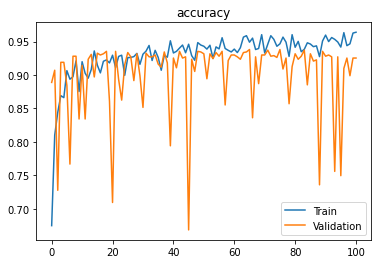

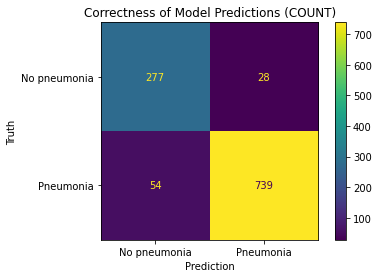

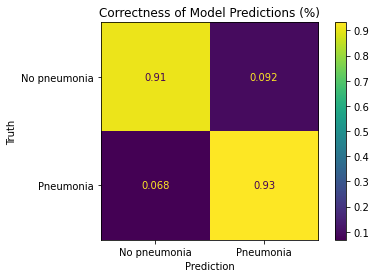

In [49]:
model_fsm = Sequential()
model_fsm.add(Flatten())
model_fsm.add(Dense(2, activation='softmax', 
             input_shape=input_shape))

model_fsm.compile(optimizer='SGD', 
                  metrics=['accuracy'], 
                  loss='categorical_crossentropy')


fit_fsm = model_fsm.fit(x=x_train, 
                        y=y_train, 
                        epochs=500,
                        validation_data=(x_val, y_val),
                        callbacks=early_stopper,
                        verbose=0)


show_model_performance(model_fsm, x_val, y_val, fit_fsm);

#### Add convolutional layer to previous model

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 32)      4736      
_________________________________________________________________
flatten_6 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 1048578   
Total params: 1,053,314
Trainable params: 1,053,314
Non-trainable params: 0
_________________________________________________________________


None

33/33 [==============================] - 1s 20ms/step - loss: 0.1039 - accuracy: 0.9626


[0.1038837805390358, 0.9626436829566956]

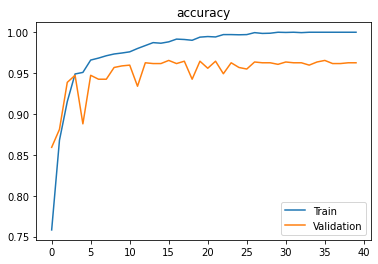

In [185]:
model = Sequential()
model.add(Conv2D(32, activation='relu',
                 kernel_size=7,  
                 input_shape=input_shape,
                 padding='same'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=early_stopper,
                validation_data=(x_val, y_val),
                verbose=0)

show_model_performance(model, x_val, y_val, fit);

#### Increase node count substantially

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 128)     86528     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2097152)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4194306   
Total params: 4,280,834
Trainable params: 4,280,834
Non-trainable params: 0
_________________________________________________________________


None

33/33 [==============================] - 7s 202ms/step - loss: 0.1704 - accuracy: 0.9569


[0.17038613557815552, 0.9568965435028076]

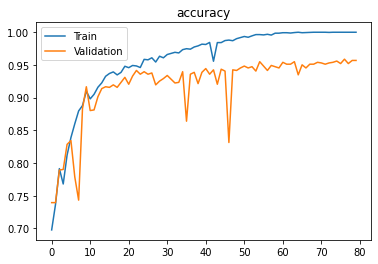

In [10]:
model = Sequential()
model.add(Conv2D(64, activation='relu',
                 kernel_size=11,  
                 input_shape=input_shape,
                 padding='same'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=early_stopper,
                validation_data=(x_val, y_val),
                verbose=0)

show_model_performance(model, x_val, y_val, fit);

#### Instead, increase depth with pooling

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 8)       1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        6288      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 32770     
Total params: 40,242
Trainable params: 40,242
Non-trainable params: 0
__________________________________________________

None

33/33 [==============================] - 0s 12ms/step - loss: 0.0874 - accuracy: 0.9770


[0.08736387640237808, 0.977011501789093]

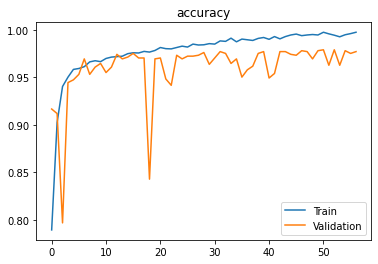

In [11]:
model = Sequential()
model.add(Conv2D(8, activation='relu',
                 kernel_size=7,  
                 input_shape=input_shape,
                 padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, activation='relu',
                 kernel_size=7,
                 padding='same'))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=callbacks,
                validation_data=(x_val, y_val),
                verbose=0)

show_model_performance(model, x_val, y_val, fit);

#### Add one more layer

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 8)       1184      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 16)        6288      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        25120     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)             

None

33/33 [==============================] - 1s 18ms/step - loss: 0.1093 - accuracy: 0.9770


[0.10930634289979935, 0.977011501789093]

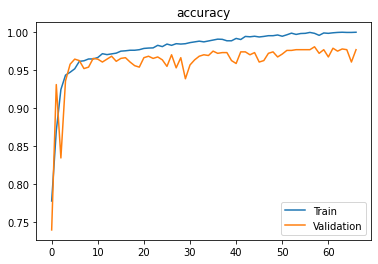

In [12]:
model = Sequential()
model.add(Conv2D(8, activation='relu',
                 kernel_size=7,  
                 input_shape=input_shape,
                 padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, activation='relu',
                 kernel_size=7, 
                 padding='same'))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, activation='relu',
                 kernel_size=7,  
                 padding='same'))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=early_stopper,
                validation_data=(x_val, y_val),
                verbose=0)

show_model_performance(model, x_val, y_val, fit);

#### Add Regularization to top performing Convolutional

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 8)       1184      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        6288      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        25120     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)             

None

33/33 [==============================] - 1s 16ms/step - loss: 0.1264 - accuracy: 0.9770


[0.12642726302146912, 0.977011501789093]

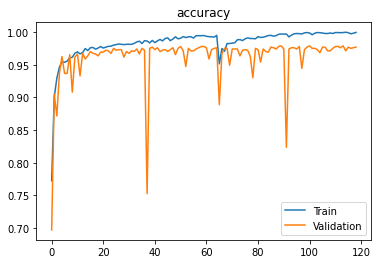

In [13]:
LAMBDA = 0.005

model = Sequential()
model.add(Conv2D(8, activation='relu',
                 kernel_size=7,  
                 input_shape=input_shape,
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, activation='relu',
                 kernel_size=7,  
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, activation='relu',
                 kernel_size=7,  
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=early_stopper,
                validation_data=(x_val, y_val),
                verbose=0)

show_model_performance(model, x_val, y_val, fit);

#### Add Dropout to top Convolutional

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 8)       1184      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        6288      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)       

None


Performance on validation data:
-------------------------------
Accuracy: 95.99 %
Precision: 96.75 %
Recall: 97.72999999999999 %
F1 score: 97.24000000000001 %


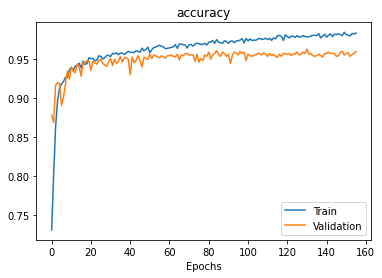

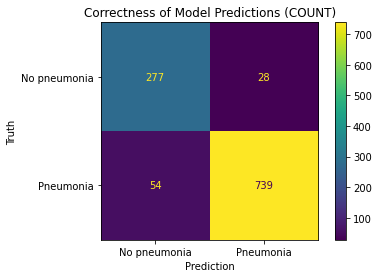

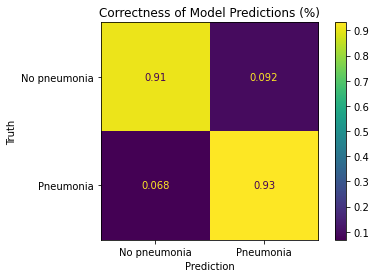

In [76]:
DROPOUT = 0.3
LAMBDA = 0.005

model = Sequential()
model.add(Conv2D(8, activation='relu',
                 kernel_size=7,  
                 input_shape=input_shape,
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(DROPOUT))

model.add(Conv2D(16, activation='relu',
                 kernel_size=7,
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(DROPOUT))

model.add(Conv2D(32, activation='relu',
                 kernel_size=7,  
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(DROPOUT))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=early_stopper,
                validation_data=(x_val, y_val),
                verbose=0)


show_model_performance(model, x_val, y_val, fit);

In [77]:
# Having established the above model as the top performer, set it as "top_model" to be evaluated on Test data
model_top = model
fit_top = fit

## Step 3. Evaluation

##### Train FSM on full dataset (Training and Validation)

In [ ]:
fit_fsm = model_fsm.fit(x=np.concatenate([x_train, x_val], axis=0), 
                        y=np.concatenate([y_train, y_val], axis=0),
                        epochs=500,
                        callbacks=early_stopper,
                        validation_split=VAL_SPLIT,
                        verbose=0)

##### Train Top Model on full dataset (Training and Validation)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 98306     
Total params: 98,306
Trainable params: 98,306
Non-trainable params: 0
_________________________________________________________________


None


Performance on validation data:
-------------------------------
Accuracy: 92.53 %
Precision: 96.35000000000001 %
Recall: 93.19 %
F1 score: 94.74000000000001 %


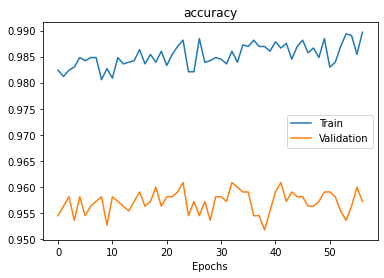

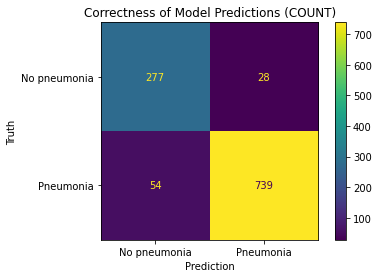

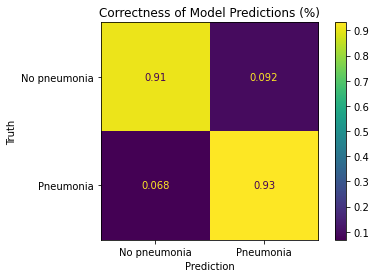

In [78]:
fit_top = model_top.fit(x=np.concatenate([x_train, x_val], axis=0), 
                        y=np.concatenate([y_train, y_val], axis=0),
                        epochs=500,
                        callbacks=early_stopper,
                        validation_split=VAL_SPLIT,
                        verbose=0)

### Measure performance on Test data

##### First Simple Model performance

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 98306     
Total params: 98,306
Trainable params: 98,306
Non-trainable params: 0
_________________________________________________________________


None


Performance on validation data:
-------------------------------
Accuracy: 92.83 %
Precision: 96.7 %
Recall: 93.35 %
F1 score: 95.0 %


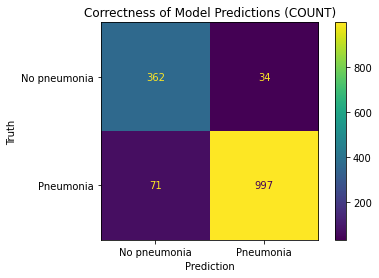

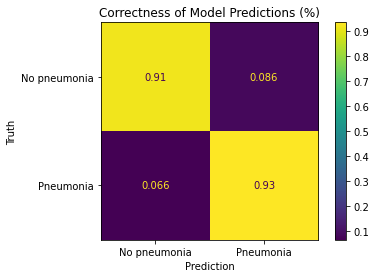

In [80]:
show_model_performance(model_fsm, x_test, y_test);

##### Top Model performance

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 8)       1184      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        6288      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)       

None


Performance on validation data:
-------------------------------
Accuracy: 96.17 %
Precision: 97.47 %
Recall: 97.28 %
F1 score: 97.38 %


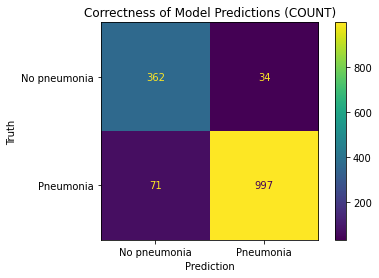

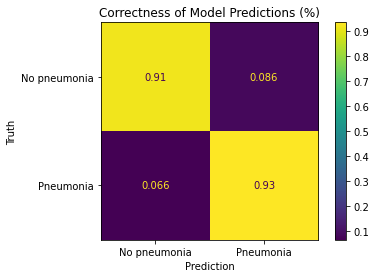

In [81]:
# CONFUSION MATRIX FOR TEST DATA, ***FSM***
show_model_performance(model_top, x_test, y_test);